In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import norm
import fitsio

import pickle
import dask

In [19]:
import dask
from dask.distributed import Client
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [20]:
import os

scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
client = Client(scheduler_file=scheduler_file)

In [21]:
client

<Client: 'tcp://10.128.0.18:43469' processes=31 threads=62, memory=3.57 TiB>

In [22]:
table_of_centers = pd.read_csv("list_of_sweeps.csv")

In [23]:
table_of_centers_sorted = table_of_centers.sort_values(by = "patch").copy().reset_index()

In [24]:
table_of_centers_n = table_of_centers_sorted[0:61].copy()
table_of_centers_s = table_of_centers_sorted[61:].copy()

In [25]:
for i in range(0, len(table_of_centers_s)):
    table_of_centers_s.at[i, "patch"] = '/global/cscratch1/sd/mjyb16/DR9/south/sweep' + table_of_centers_s.iloc[i].patch[71:]
    table_of_centers_s.at[i, "photoz"] = '/global/cscratch1/sd/mjyb16/DR9/south/photo-z' + table_of_centers_s.iloc[i].photoz[79:]
    table_of_centers_s.at[i, "masses"] = '/global/cscratch1/sd/mjyb16/DR9/south/stellar_mass' + table_of_centers_s.iloc[i].masses[70:]

for i in range(0, len(table_of_centers_n)):
    table_of_centers_n.at[i, "patch"] = '/global/cscratch1/sd/mjyb16/DR9/north/sweep' + table_of_centers_n.iloc[i].patch[71:]
    table_of_centers_n.at[i, "photoz"] = '/global/cscratch1/sd/mjyb16/DR9/north/photo-z' + table_of_centers_n.iloc[i].photoz[79:]
    table_of_centers_n.at[i, "masses"] = '/global/cscratch1/sd/mjyb16/DR9/north/stellar_mass' + table_of_centers_n.iloc[i].masses[70:]

In [26]:
np.random.seed(1)

In [27]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

def data_importer(row):
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    ra_dec = data_import(maxx, maxy, minx, miny, row)
    #print(len(ra_dec))
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)].copy()
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)].copy()
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    #print(l_mask)
    #print(len(ra_dec))
    #print(len(ra_dec[l_mask]))
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)].copy()
    ra_dec = ra_dec[ra_dec.TYPE != "PSF"].copy()

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    ra_dec.reset_index(inplace = True, drop = True)
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss))

    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    #print(len(ra_dec))
    return ra_dec

In [28]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
oversample = 30
buffer = 0.285
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

radius = 1
small_radius = 0.5
mini_radius = 0.1

z_bins = np.arange(0.05, 1.5, 0.01)

In [29]:
@dask.delayed()
def background_counter(data, ra, dec, mra, mdec):
    ra_dec = data_importer(data)
    if len(ra_dec) == 0:
        return []
    y = (np.pi/180)*dec - (np.pi/180)*mdec + 50
    x = (np.pi/180)*(ra - mra)*np.cos((np.pi/180)*dec) + 50
    #print(y, x)
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    neighbors = tree.query_ball_point([x, y], radius_threshold(0.02))
    onempc = np.zeros(len(z_bins))
    halfmpc = np.zeros(len(z_bins))
    tenthmpc = np.zeros(len(z_bins))
    
    if len(neighbors) > 0:
        for i in range(len(z_bins)):
            local_data = indexable[neighbors]

            z_c = z_threshold(z_bins[i])
            cylinder = np.abs(np.vstack(local_data[:, 4]) - z_bins[i])
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]
            
            r_smaller = radius_threshold(z_bins[i])
            large_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < r_smaller]
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.1*r_smaller]
            
            c_mask = large_cluster[:, 3]>mass_limit(z_bins[i])
            large_cluster_limited = large_cluster[c_mask.astype("bool"), :]
            c_mask = small_cluster[:, 3]>mass_limit(z_bins[i])
            small_cluster_limited = small_cluster[c_mask.astype("bool"), :]
            c_mask = mini_cluster[:, 3]>mass_limit(z_bins[i])
            mini_cluster_limited = mini_cluster[c_mask.astype("bool"), :]
            
            onempc[i] = np.log10(np.sum((10**large_cluster_limited[:, 3])*large_cluster_limited[:, -1]))
            halfmpc[i] = np.log10(np.sum((10**small_cluster_limited[:, 3])*small_cluster_limited[:, -1]))
            tenthmpc[i] = np.log10(np.sum((10**mini_cluster_limited[:, 3])*mini_cluster_limited[:, -1]))
            
    return [onempc, halfmpc, tenthmpc]

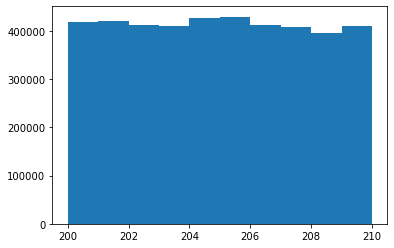

(5.447542160196222, 204.9691733695541, 209.99999870514372)
0


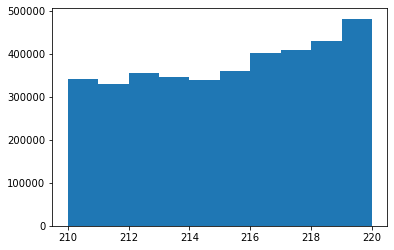

(5.009490609508521, 215.32213145853657, 219.9999978399011)


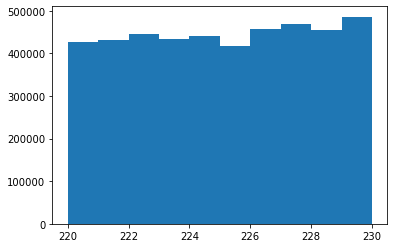

(4.864809263390977, 225.0968960321274, 229.99999985257026)


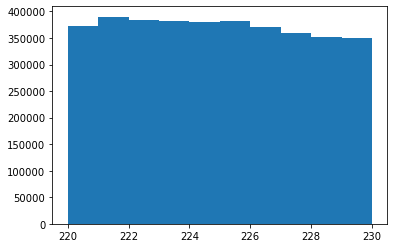

(4.882833256061327, 224.9129523138706, 229.99999703232814)


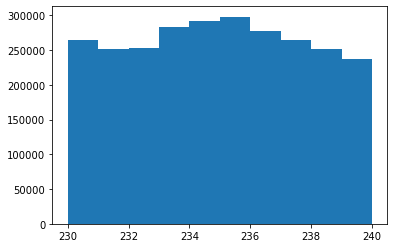

(15.01190433020598, 234.9621544365968, 239.99999603293168)


In [24]:
results_n = []
for it in range(0, 5):
    data_r = table_of_centers_n.iloc[it]
    fits_data = fitsio.FITS(data_r.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    ra = np.random.uniform(low = minx, high = maxx)
    dec = np.random.uniform(low = miny, high = maxy)
    mra = np.mean(sweep['RA'])
    mdec = np.mean(sweep['DEC'])
    if it%10 == 0:
        print(it)
    results_n.append(background_counter(data_r, ra, dec, mra, mdec))

In [13]:
results_n = []
for it in range(0, 44):
    data_r = table_of_centers_n.iloc[it]
    fits_data = fitsio.FITS(data_r.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    mra = np.mean(sweep['RA'])
    mdec = np.mean(sweep['DEC'])
    for i in range(20):
        ra = np.random.uniform(low = minx, high = maxx)
        dec = np.random.uniform(low = miny, high = maxy)
        #print(((np.pi/180)*(ra - mra), (np.pi/180)*(dec - mdec)))
        results_n.append(background_counter(data_r, ra, dec, mra, mdec))

In [14]:
background_n = dask.persist(*results_n)
#progress(background_n) 

In [15]:
background_n = dask.compute(*background_n)

In [17]:
background_n[:41]

([],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([11.81714369, 11.7049966 , 11.5156497 , 11.58979796, 11.67583543,
         11.58605119, 11.50978529, 11.5684383 , 11.53141313, 11.63668775,
         11.64982522, 11.71937843, 11.77075153, 11.82946906, 11.94449099,
         11.99668651, 12.09505253, 12.16643813, 12.21130133, 12.26557352,
         12.24421155, 12.26250352, 12.26780732, 12.30076973, 12.32318898,
         12.3180059 , 12.30049556, 12.30870865, 12.31641905, 12.31520338,
         12.31907214, 12.33156884, 12.33204595, 12.32687351, 12.33130368,
         12.33163283, 12.32229197, 12.32831513, 12.29909274, 12.31611489,
         12.29184193, 12.25993439, 12.22086672, 12.22399322, 12.26637883,
         12.28010922, 12.32955065, 12.34036754, 12.33347186, 12.29720411,
         12.29802579, 12.30045267, 12.28291967, 12.28481785,

In [22]:
soriginal_1 = background_n[40][0].reshape((len(background_n[40][0]), 1))
soriginal_05 = background_n[40][1].reshape((len(background_n[40][0]), 1))
soriginal_01 = background_n[40][2].reshape((len(background_n[40][0]), 1))
for i in range(41, 880):
    if len(background_n[i]) > 0:
        if np.mean(background_n[i][0][np.isfinite(background_n[i][0])]) > 0:
            soriginal_1 = np.append(soriginal_1, background_n[i][0].reshape((len(background_n[40][0]), 1)), axis = 1)
            soriginal_05 = np.append(soriginal_05, background_n[i][1].reshape((len(background_n[40][0]), 1)), axis = 1)
            soriginal_01 = np.append(soriginal_01, background_n[i][2].reshape((len(background_n[40][0]), 1)), axis = 1)

/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
np.save("third_north_monte_carlo_mbackground_1", soriginal_1)
np.save("third_north_monte_carlo_mbackground_05", soriginal_05)
np.save("third_north_monte_carlo_mbackground_01", soriginal_01)

In [58]:
soriginal_1 = np.load("third_north_monte_carlo_mbackground_1.npy")
soriginal_05 = np.load("third_north_monte_carlo_mbackground_05.npy")
soriginal_01 = np.load("third_north_monte_carlo_mbackground_01.npy")

In [11]:
soriginal_1.shape

(145, 661)

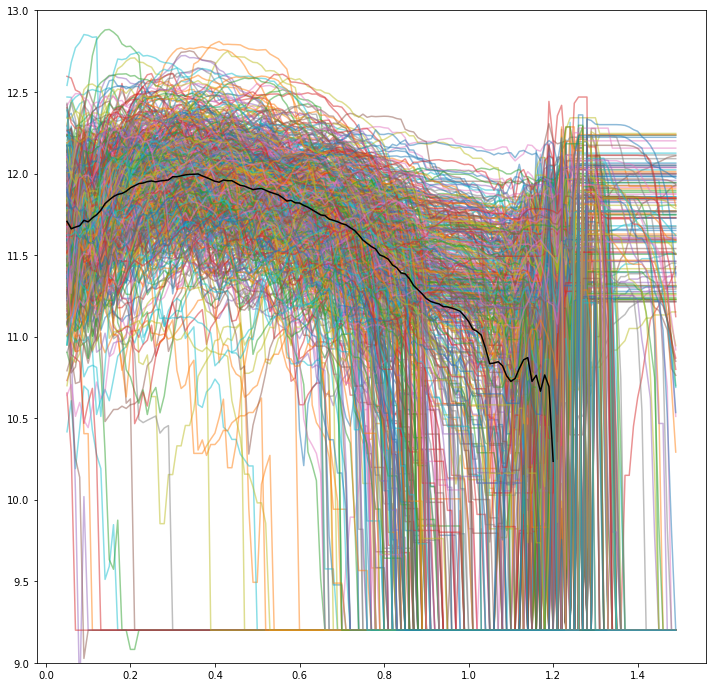

In [64]:
plt.figure(figsize = (12, 12))
for i in range(661):
    if len(soriginal_1[:, i]) > 0:
        medians = soriginal_1[:, i].copy()
        medians[medians == -np.inf] = 9.2
        plt.plot(z_bins, medians, "-", alpha = 0.5)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(soriginal_1, axis = 1), "-k")
#plt.plot(z_bins, np.median(soriginal_1, axis = 1), "-r")
plt.ylim(9, 13)
plt.show()

In [54]:
soriginal_1[:, 0:10]

array([[11.81714369, 11.48027884, 11.95646026, ..., 11.92606098,
        11.80403832, 10.41640282],
       [11.7049966 , 11.43958263, 11.935907  , ..., 12.00031756,
        11.71898313, 10.60692602],
       [11.5156497 , 10.91093227, 11.75887518, ..., 11.69653423,
        11.44274494, 10.19079147],
       ...,
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf]])

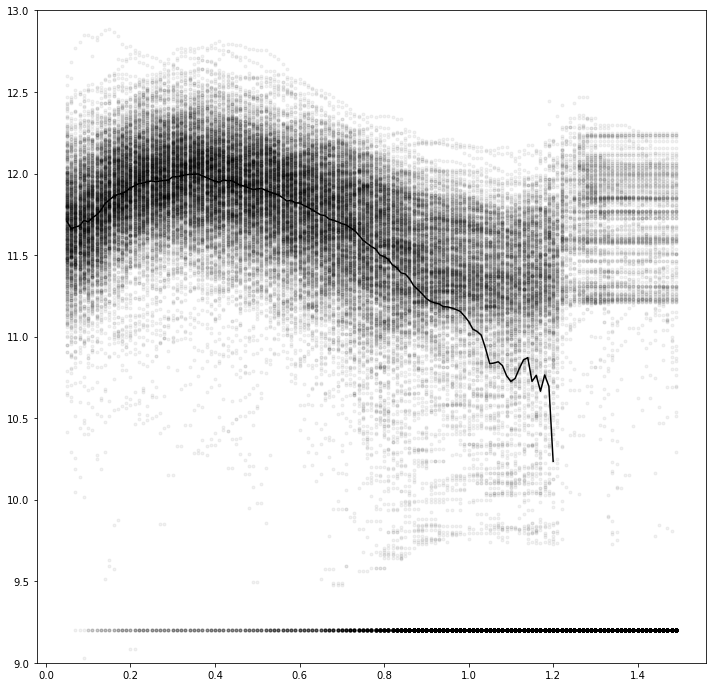

In [60]:
plt.figure(figsize = (12, 12))
for i in range(661):
    if len(soriginal_1[:, i]) > 0:
        medians = soriginal_1[:, i].copy()
        medians[medians == -np.inf] = 9.2
        plt.plot(z_bins, medians, ".k", alpha = 0.05)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(soriginal_1, axis = 1), "-k")
#plt.plot(z_bins, np.median(soriginal_1, axis = 1), "-r")
plt.ylim(9, 13)
plt.show()

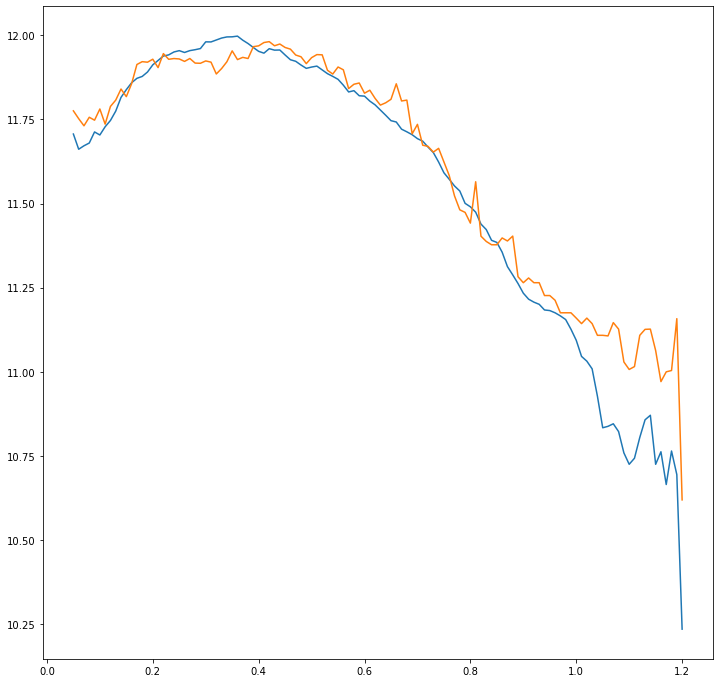

In [18]:
final_n = pd.read_csv("~/north_mass_background_best.csv")

plt.figure(figsize = (12, 12))
plt.plot(z_bins, np.median(soriginal_1, axis = 1))
plt.plot(final_n.z, final_n["1mpcbkgd"])

In [30]:
results_s = []
for it in range(0, 44):
    data_r = table_of_centers_s.iloc[it]
    fits_data = fitsio.FITS(data_r.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    mra = np.mean(sweep['RA'])
    mdec = np.mean(sweep['DEC'])
    for i in range(20):
        ra = np.random.uniform(low = minx, high = maxx)
        dec = np.random.uniform(low = miny, high = maxy)
        #print(((np.pi/180)*(ra - mra), (np.pi/180)*(dec - mdec)))
        results_s.append(background_counter(data_r, ra, dec, mra, mdec))

In [31]:
background_s = dask.persist(*results_s)

In [32]:
background_s = dask.compute(*background_s)

In [38]:
background_s

([array([11.13294352, 11.17211949, 11.28903165, 11.22713335, 11.60600728,
         11.65969887, 11.73692547, 11.78853622, 11.81362077, 11.721268  ,
         11.7447725 , 11.59277838, 11.55071629, 11.59014789, 11.67516107,
         11.75540573, 11.75851231, 11.81355079, 11.79479254, 11.86355368,
         11.84271981, 11.90377021, 11.88708035, 11.95053193, 12.02766941,
         12.13105149, 12.19927457, 12.23497657, 12.29610943, 12.32880251,
         12.34935043, 12.36309112, 12.37201927, 12.3821757 , 12.38192547,
         12.37409172, 12.3821926 , 12.37168334, 12.37002446, 12.33650802,
         12.32691115, 12.30070462, 12.26916296, 12.26749943, 12.20538917,
         12.1740148 , 12.14533377, 12.10661106, 12.03459764, 11.9711951 ,
         11.91685912, 11.84918495, 11.79951519, 11.74731538, 11.68211577,
         11.64205281, 11.62887274, 11.61467261, 11.62500923, 11.61870433,
         11.6214644 , 11.62735262, 11.57141889, 11.58432421, 11.58806083,
         11.60449436, 11.56513915, 11.

In [35]:
original_1_s = background_s[0][0].reshape((len(background_s[0][0]), 1))
original_05_s = background_s[0][1].reshape((len(background_s[0][0]), 1))
original_01_s = background_s[0][2].reshape((len(background_s[0][0]), 1))

In [36]:
for i in range(1, 880):
    if len(background_s[i]) > 0:
        if np.mean(background_s[i][0][np.isfinite(background_s[i][0])]) > 0:
            original_1_s = np.append(original_1_s, background_s[i][0].reshape((len(background_s[0][0]), 1)), axis = 1)
            original_05_s = np.append(original_05_s, background_s[i][1].reshape((len(background_s[0][0]), 1)), axis = 1)
            original_01_s = np.append(original_01_s, background_s[i][2].reshape((len(background_s[0][0]), 1)), axis = 1)

/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


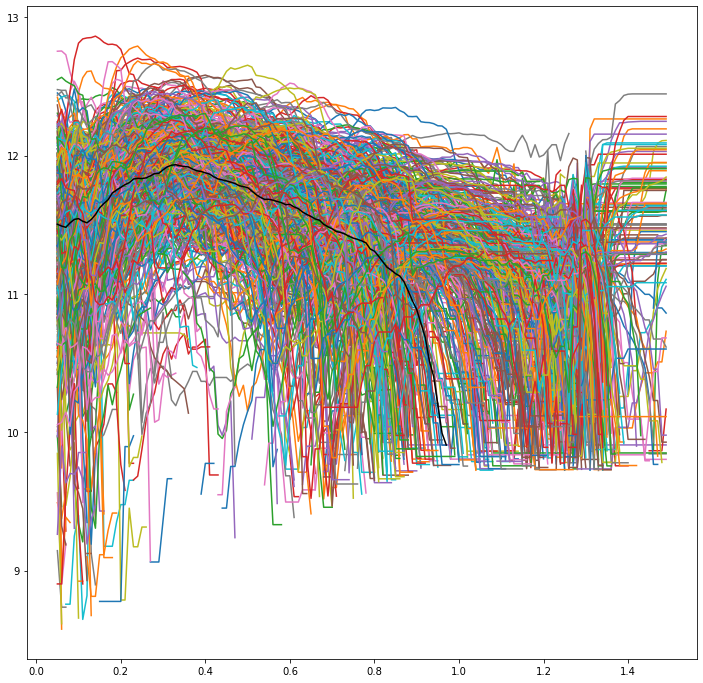

In [42]:
import warnings

warnings.filterwarnings('ignore')
plt.figure(figsize = (12, 12))
for i in range(880):
    #print(i)
    if len(background_s[i]) > 0:
        if np.mean(background_s[i][0][np.isfinite(background_s[i][0])]) > 0:
            plt.plot(z_bins, background_s[i][0], "-")
            #plt.plot(z_bins, background_n[i][1], "-")
            #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.show()

In [62]:
background_s2[0:44]

([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 

In [58]:
len(original_1_s)

145

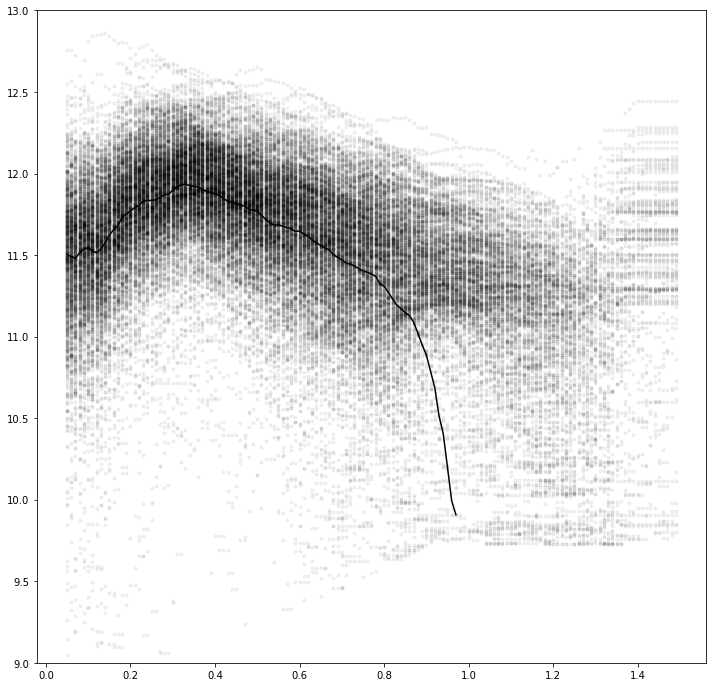

In [44]:
import warnings

warnings.filterwarnings('ignore')
plt.figure(figsize = (12, 12))
for i in range(880):
    if len(background_s[i]) > 0:
        plt.plot(z_bins, background_s[i][0], ".k", alpha = 0.05)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.ylim(9, 13)
plt.show()

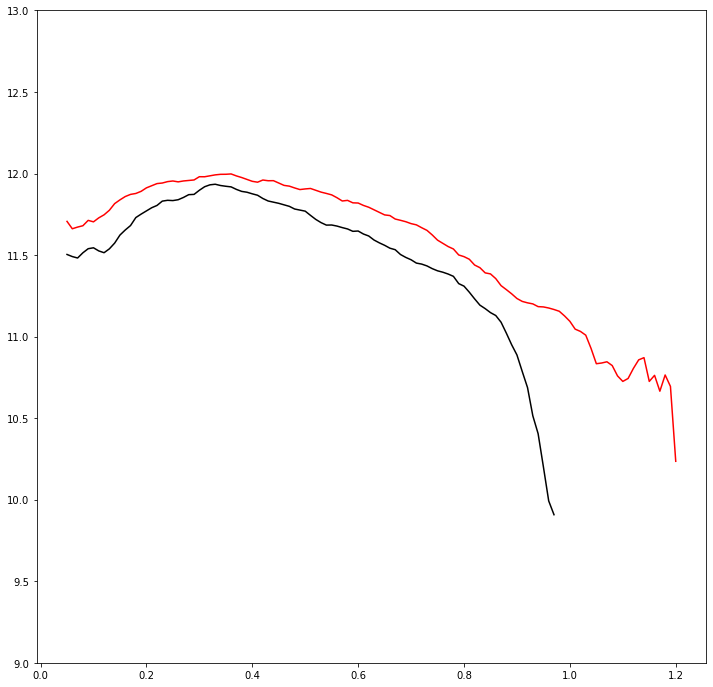

In [47]:
plt.figure(figsize = (12, 12))
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.plot(z_bins, np.median(soriginal_1, axis = 1), "-r")
plt.ylim(9, 13)
plt.show()

(9.0, 13.0)

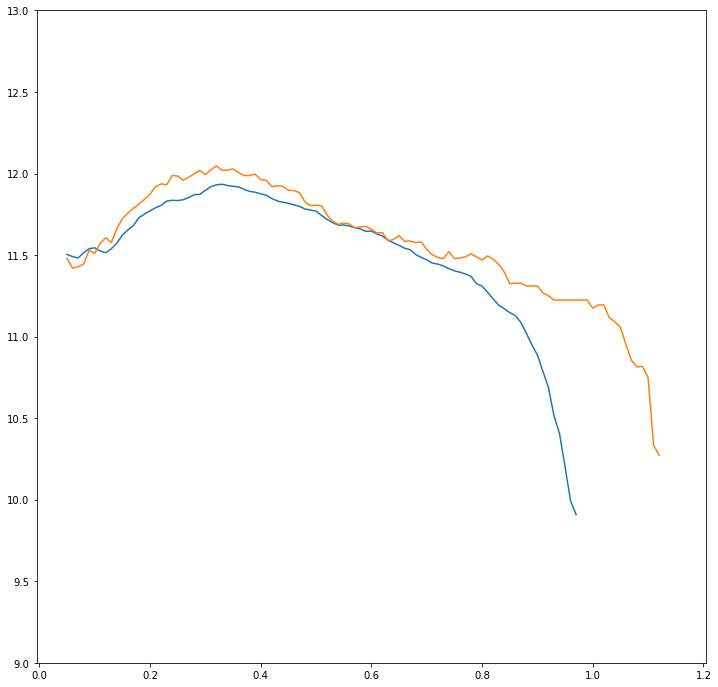

In [45]:
final_n = pd.read_csv("~/south_mass_background_best2.csv")

plt.figure(figsize = (12, 12))
plt.plot(z_bins, np.median(original_1_s, axis = 1))
plt.plot(final_n.z, final_n["1mpcbkgd"])
plt.ylim(9, 13)

In [46]:
np.save("third_south_monte_carlo_mbackground_1", original_1_s)
np.save("third_south_monte_carlo_mbackground_05", original_05_s)
np.save("third_south_monte_carlo_mbackground_01", original_01_s)

In [ ]:
final_s = pd.read_csv("~/south_mass_background_final.csv")

plt.figure(figsize = (12, 12))
plt.plot(z_bins, np.median(original_1_s, axis = 1))
plt.plot(final_s.z, final_s["1mpcbkgd"])

In [48]:
data_north = np.array([z_bins, np.median(soriginal_1, axis = 1), np.median(soriginal_05, axis = 1), np.median(soriginal_01, axis = 1)])

In [49]:
pd_north = pd.DataFrame(data_north.T, columns = [["z", "1mpcbkgd", "halfmpcbkgd", "tenthmpcbkgd"]])

In [50]:
pd_north.to_csv("north_mass_background_final_third.csv")

In [51]:
data_south = np.array([z_bins, np.median(original_1_s, axis = 1), np.median(original_05_s, axis = 1), np.median(original_01_s, axis = 1)])
pd_south = pd.DataFrame(data_south.T, columns = [["z", "1mpcbkgd", "halfmpcbkgd", "tenthmpcbkgd"]])

In [52]:
pd_south.to_csv("south_mass_background_final_third.csv")

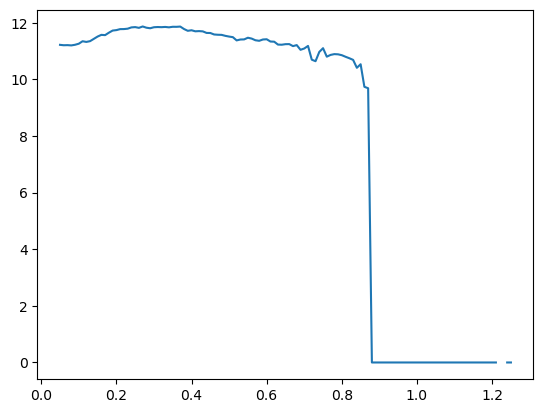

In [18]:
plt.plot(pd_north.z, pd_south["1mpcbkgd"])

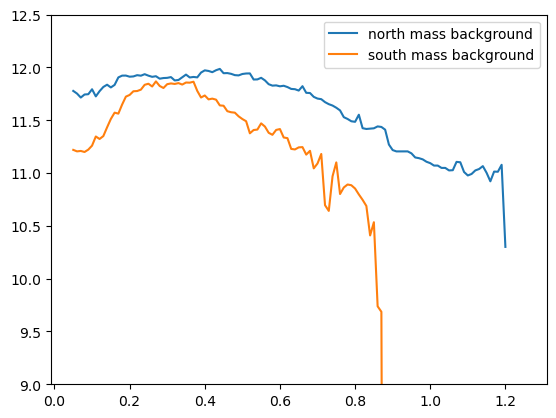

In [29]:
pd_north = pd.read_csv("north_mass_background_limited.csv")
pd_south = pd.read_csv("south_mass_background_limited.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north mass background")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south mass background")
plt.legend()
plt.ylim(9, 12.5)
plt.show()

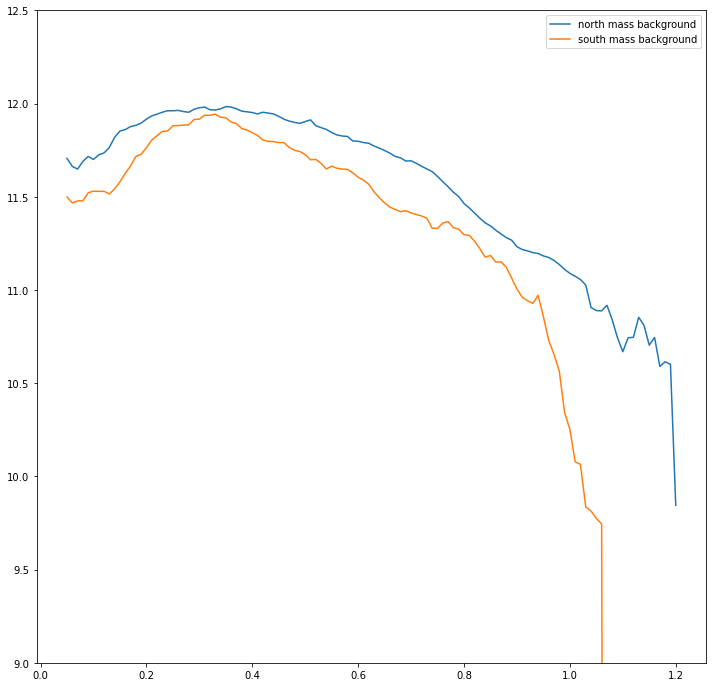

In [49]:
plt.figure(figsize = (12, 12))
pd_north = pd.read_csv("north_mass_background_final.csv")
pd_south = pd.read_csv("south_mass_background_final.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north mass background")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south mass background")
plt.legend()
plt.ylim(9, 12.5)
plt.show()

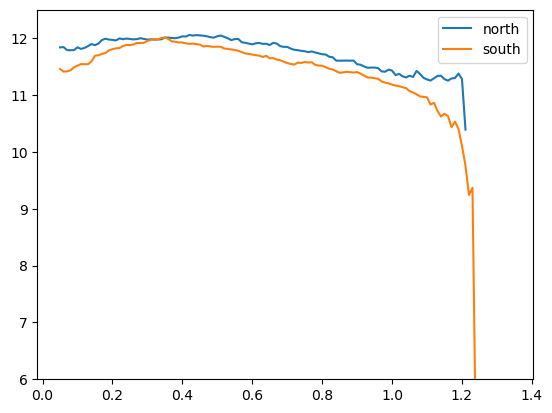

In [27]:
pd_north = pd.read_csv("north_mass_background_no_star.csv")
pd_south = pd.read_csv("south_mass_background_no_star.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south")
plt.legend()
plt.ylim(6, 12.5)
plt.show()

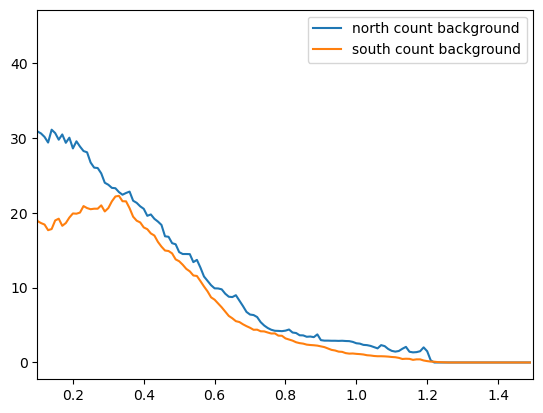

In [4]:
pd_north = pd.read_csv("north_background_no_star.csv")
pd_south = pd.read_csv("south_background_no_star.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north count background")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south count background")
plt.legend()
plt.xlim(0.1, 1.5)
plt.show()